# Compare TMA balancing data from previous balancing events with the next events

```{abstract}
The telescope balancing will be done in two steps. First, we will balance the telescope with ComCam and M2 Glass. The M2 Glass and M2 Surrogate have similar weights, with a small difference. We expect that the torques applied by the elevation drives to be very close to the previous balancing events. A couple of weeks later, we will repeat the procedure with ComCam, M2 Glass, and M1M3 Glass. The M1M3 Glass and M1M3 Cell assembly is much heavier than the M1M3 Mass Simulator (yellow cross) and hundreds of kilograms heavier than the M1M3 Surrogate and M1M3 Cell configuration. This procedure will be much more delicate due to the size and mass of the mirror.
```

We want to establish a baseline before we start the procedure by producing a set of reference plots of Torque versus Elevation angle corresponding to the various telescope configurations:
1. M2 Surrogate and Cell on TMA
2. M1M3 Surrogate and M1M3 Cell on TMA
3. M1M3 Surrogate and Cell + M2 Surrogate and Cell on TMA

## Associated JIRA tickets

- [SITCOM-1508](https://rubinobs.atlassian.net/browse/SITCOM-1508)

## Datasets

The links below point to old night logs that might contain useful information.

Here is an approximate timeline of different integration phases where we needed to re-balance the telescope. We do not necessarily need the whole process. We need the torques once the telescope is already balanced as a baseline.
- May to Aug 2023: M1M3 Surrogate and M1M3 Cell on the TMA
- Nov 2023 to Jan 2024: M1M3 Surrogate and Cell, M2 Surrogate and Cell on the TMA
- Feb to Apr 2024: M2 Surrogate and Cell on the TMA

The dates where the new balancing process was performed are the following:
-  ComCam and M2 glass on its cell + yellow cross: 2024/09/03 between 14:30 and 16:30 (UTC)

After investigating the various possible datasets we found that 
the most interesting data for this analysis are those from BLOCK-177 https://rubinobs.atlassian.net/browse/BLOCK-177
initially designed for laser tracker tests.
The TMA is still on the azimuth axis and the elevation increases and decreases by steps of 5 (or 10 ?) degrees

Unfortunately BLOCK-177 wasn't run very often and we are missing clean data samples.

## Method

The relevant metrics to characterize the telescope balancing is the torque value as a function of the elevation angle. 

In order to get accurate measurements we need to select data where both the TMA (Telescope Mount Assembly) is still in both azimuth and elevation during the torque measurements.
As there is an hysteresis effect on the torque, we also need to check the rotation direction (direct or indirect) of the TMA in elevation before reaching the measurement position.
As we will see later, in order to get a clean measurement, we should also make sure that the TMA is still in azimuth during the whole measurement period. If the TMA moves in azimuth, it will add
a an extra component to the torque.

In order to check that the TMA is still, we check the EFD topics:
- lsst.sal.MTMount.logevent_azimuthMotionState
- lsst.sal.MTMount.logevent_elevationMotionState
Which should be both equal to 1 (motion state == stopped)

As the the motion states are stored in separate topics, the timestamps of both series are not identical, so we need to perform an extra computation to find the overlaping time periods 
where both motion states are "stopped".

## Dates with interesting data

We have identified the following time periods:

### Data before glass installation

May to Aug 2023 - M1M3 Surrogate and M1M3 Cell on the TMA

* 2023-06-22

Nov 2023 to Jan 2024 - M1M3 Surrogate and Cell, M2 Surrogate and Cell on the TMA

* 2024-01-06 - Az: 59.6 deg - Block 177 between 09:00 and 10:00
* 2024-01-09 - Az: 59.6 deg
* 2024-01-10 - Az: 60.3 deg
* 2024-01-12 - Az: 0 deg

Feb to Apr 2024 - M2 Surrogate and Cell on the TMA

 * 2024-03-28

### Data after glass installation

Coarse balance with Yellow cross - M2+Cell and ComCam on TMA 

* 2024-09-03 14:30 - 16:00

In [1]:
# Notebook extensions for formatting and auto-reload libraries
%matplotlib inline
%load_ext lab_black
%load_ext autoreload
%autoreload 2

# Standard Python Libraries
import os

module_path = os.path.abspath(os.path.join("."))
sys.path.append(module_path + "/python")

# Import utility functions from the python directory
from utils import *

# Create a directory to save plots (may be useless with notebook based TN ?)
plot_dir = "./plots"
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [2]:
# Define the time period that we are going to investigate

# date_dict = {
#    "date": "2024-01-06",
#    "start_time": "09:00:00.00",
#    "end_time": "10:00:00.00",
# }
date_dict = {
    "date": "2024-09-03",
    "start_time": "14:30:00.00",
    "end_time": "16:00:00.00",
}
# date_dict = {
#    "date": "2024-01-03",
#    "start_time": "08:30:00.00",
#    "end_time": "09:30:00.00",
# }

## Analysis

In the following we analyse data corresponding to the various identified configurations. The main results will be plots of elevation torque as a function 
of the elevation angle. We will distinguish cases where the TMA moved in the positive direction (low --> high angle) before reaching the measurement position from the cases
where it moved in the negative direction (high to low angle). Positive will be indicated by the green color and negative by the red color.
The points

The second kind of plots is showing the behavior of the following quantities in chronological order:

- Elevation angle
- Elevation torque
- Azimuth angle
- Elevation speed

The periods of time where the analysis is done are indicated by green and red segments with the same color coding as for the previous plot.

## Analysis of M2 Glass + Cell + Yellow cross

### 2024-09-03
This is a TMA movement in elevation from horizon to zenith with a coarse balancing

In [3]:
date_dict = {
    "date": "2024-09-03",
    "start_time": "14:30:00.00",
    "end_time": "16:00:00.00",
}

df, sel_azi, client = await init_and_compute(date_dict, "usdf_efd")

No status data found for azimuth axis, using full time range
We found 20 time periods where the TMA is still in both azimuth and elevation
The most common TMA azimuth angle is: 148.8 degrees - # of occurences: 19


### Torque versus Elevation Angle

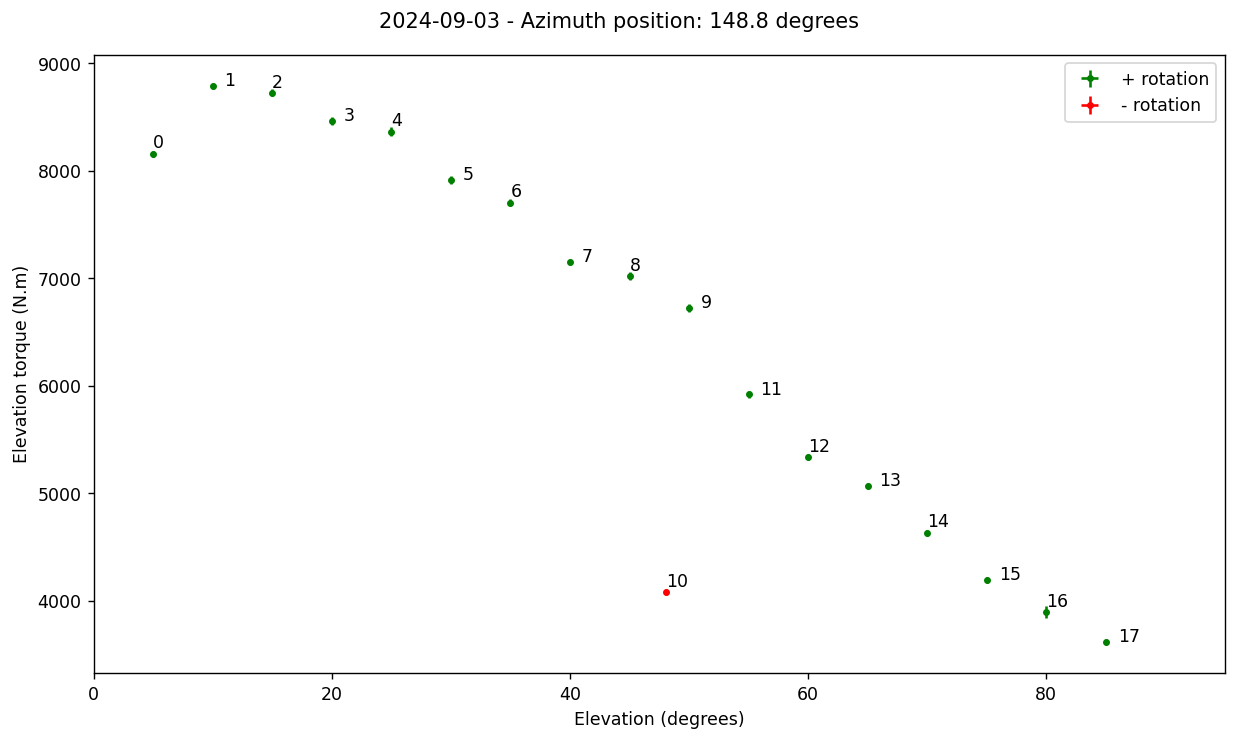

In [4]:
# Plot torque versus elevation angle
plot_torque_versus_elevation(df, date_dict["date"], sel_azi, plot_dir)

The red point labeled "10" correspond to a situation where the home command was briefly sent to the TMA which then rotated backward before resuming its movement toward
zenith. The point is below the green curve as a result of the hysteresis.

### Plot data in chronological order

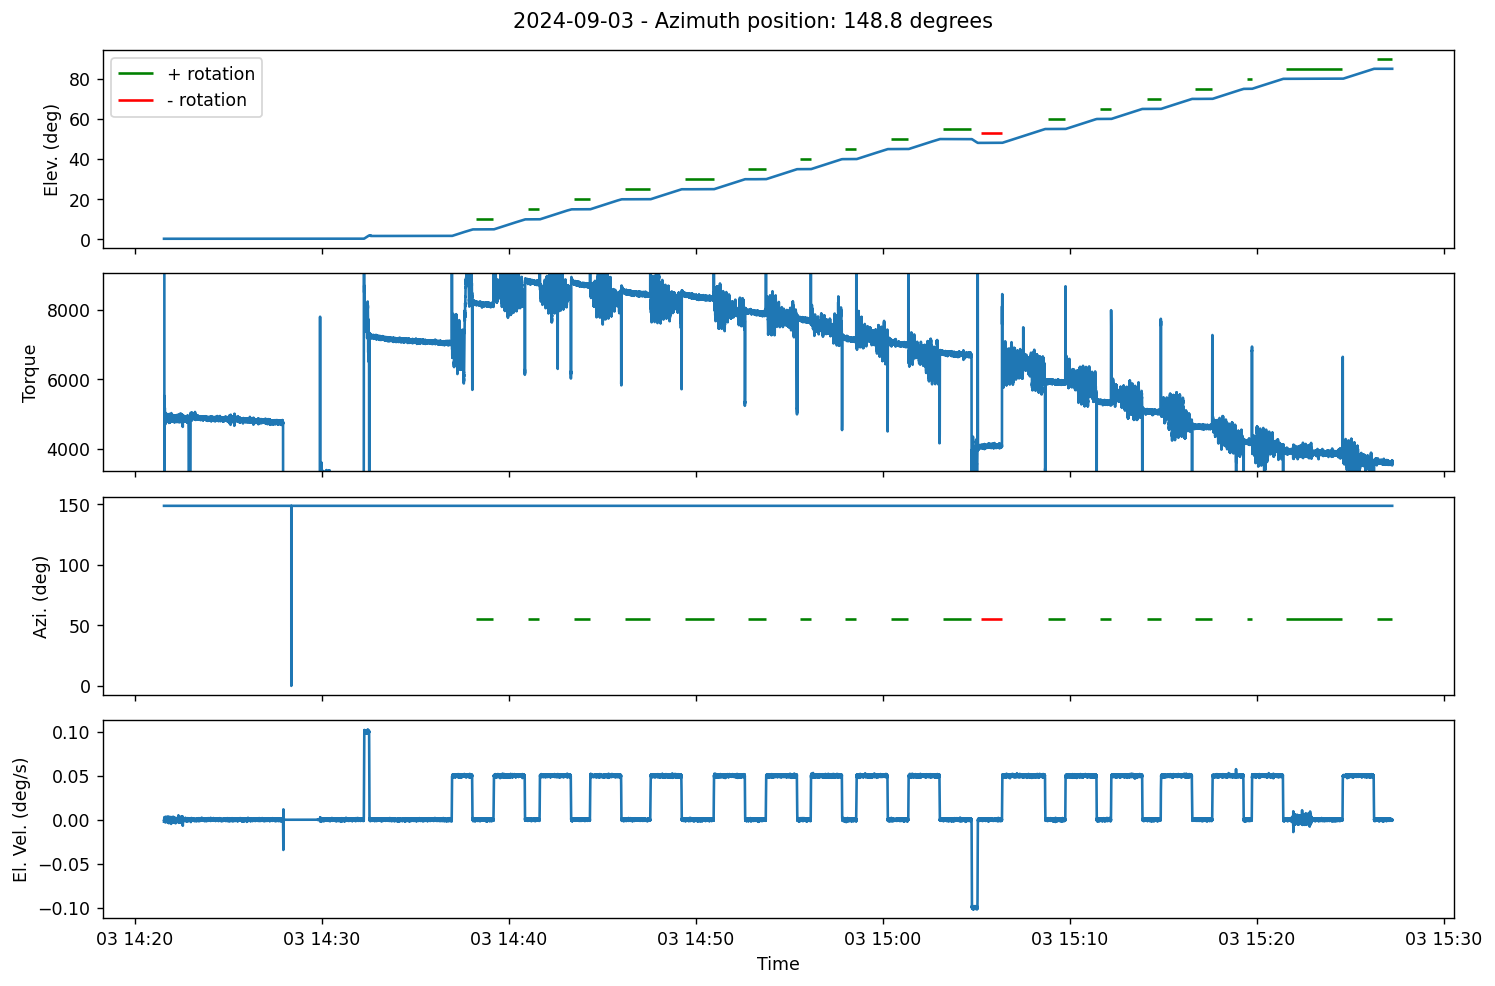

In [5]:
# We will retrieve data back t_back seconds in the past
t_back = 1000
plot_history(df, client, t_back, date_dict["date"], sel_azi, plot_dir, save_plot=True)

## Analysis of M1M3 Surrogate + Cell + M2 Surrogate + Cell

### 2024-01-06
This is a TMA movement in elevation from horizon to zenith and back with BLOCK-177

In [6]:
date_dict = {
    "date": "2024-01-06",
    "start_time": "09:00:00.00",
    "end_time": "10:00:00.00",
}
df, sel_azi, client = await init_and_compute(date_dict, "usdf_efd")

We found 16 time periods where the TMA is still in both azimuth and elevation
The most common TMA azimuth angle is: 152.5 degrees - # of occurences: 14


### Torque versus Elevation Angle

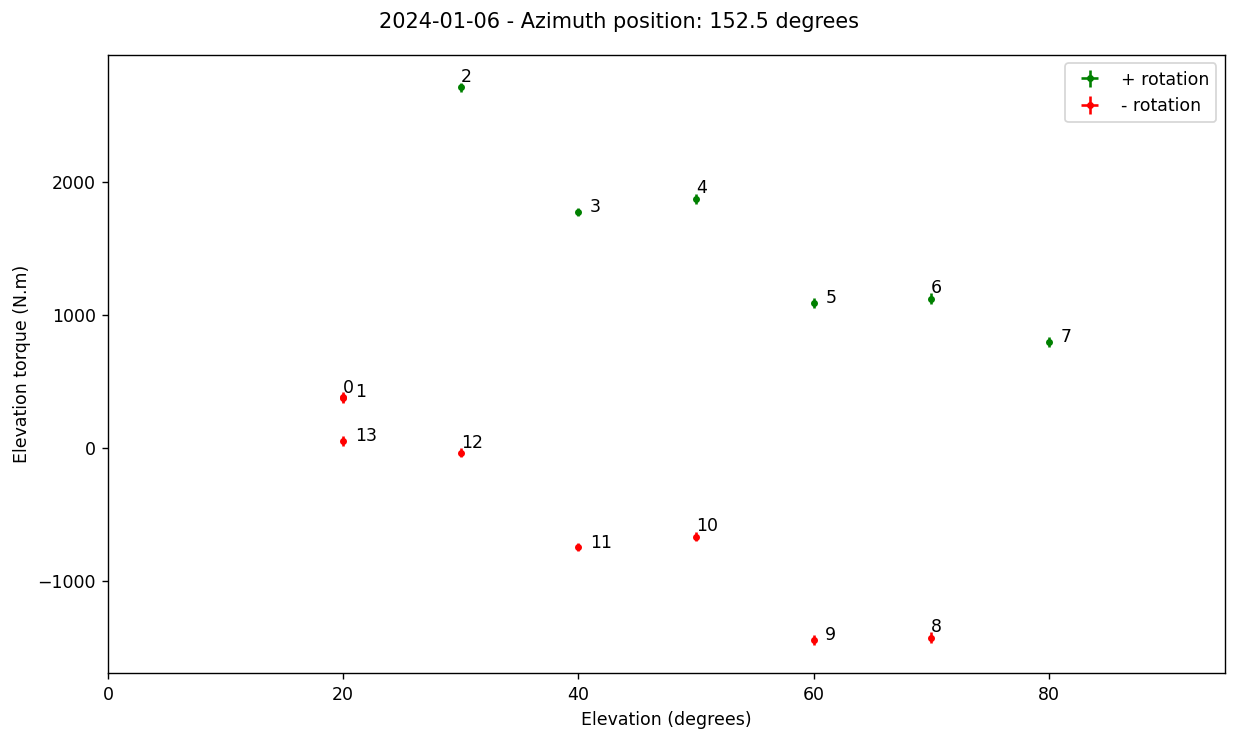

In [7]:
# Plot torque versus elevation angle
plot_torque_versus_elevation(df, date_dict["date"], sel_azi, plot_dir)

### Plot data in chronological order

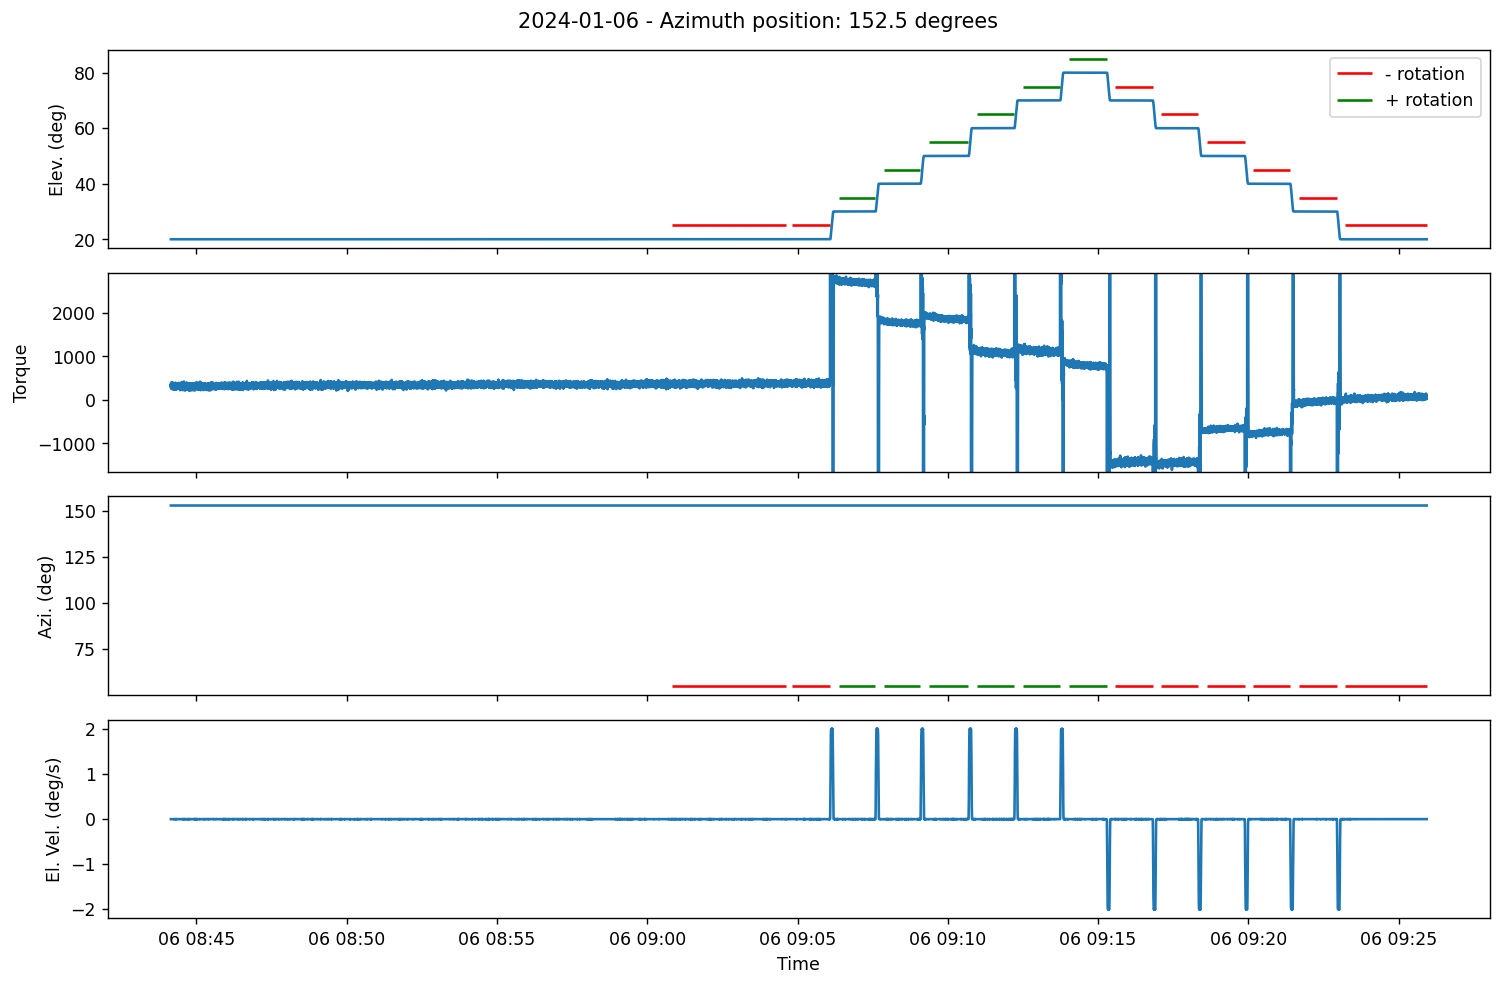

In [8]:
# We will retrieve data back t_back seconds in the past
t_back = 1000
plot_history(df, client, t_back, date_dict["date"], sel_azi, plot_dir, save_plot=True)

We see that the data sample is clean, thanks to the azimuth angle which is strictly constant during the analysis but we are missing data points especially at low elevation angle

### 2024-01-10

With this data sample, we have more data points but even if the azimuth angle is always the same (60.3 degrees) during the torque measurements, it is changing between the
measurements. This is adding a component to the torque measured on the elevation axis and is the reason why we see a spread on the data points.

In [9]:
date_dict = {
    "date": "2024-01-10",
    "start_time": "00:00:00.00",
    "end_time": "23:59:00.00",
}
df, sel_azi, client = await init_and_compute(date_dict, "usdf_efd")

We found 432 time periods where the TMA is still in both azimuth and elevation
The most common TMA azimuth angle is: 60.3 degrees - # of occurences: 193


### Torque versus Elevation Angle

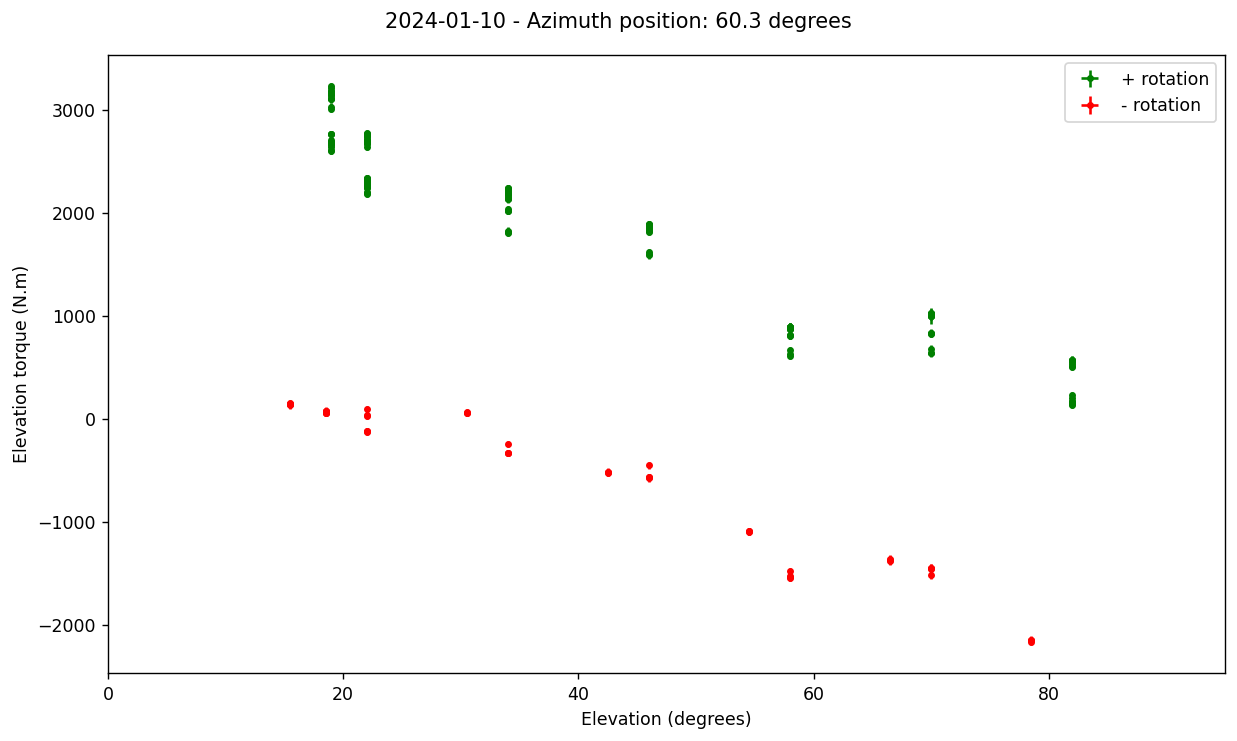

In [10]:
# Plot torque versus elevation angle
plot_torque_versus_elevation(
    df, date_dict["date"], sel_azi, plot_dir, print_numbers=False
)

The sequence of events in chronological order can be understood on the following plot corresponding to the points around elevation=21 degrees.

The jumps in the torque values related to change in azimuth position between the measurements are particularly clear around 00:25 - 00:32 and 00:48 - 00:55

We found 66 time periods where the TMA is still in both azimuth and elevation
The most common TMA azimuth angle is: 60.0 degrees - # of occurences: 29


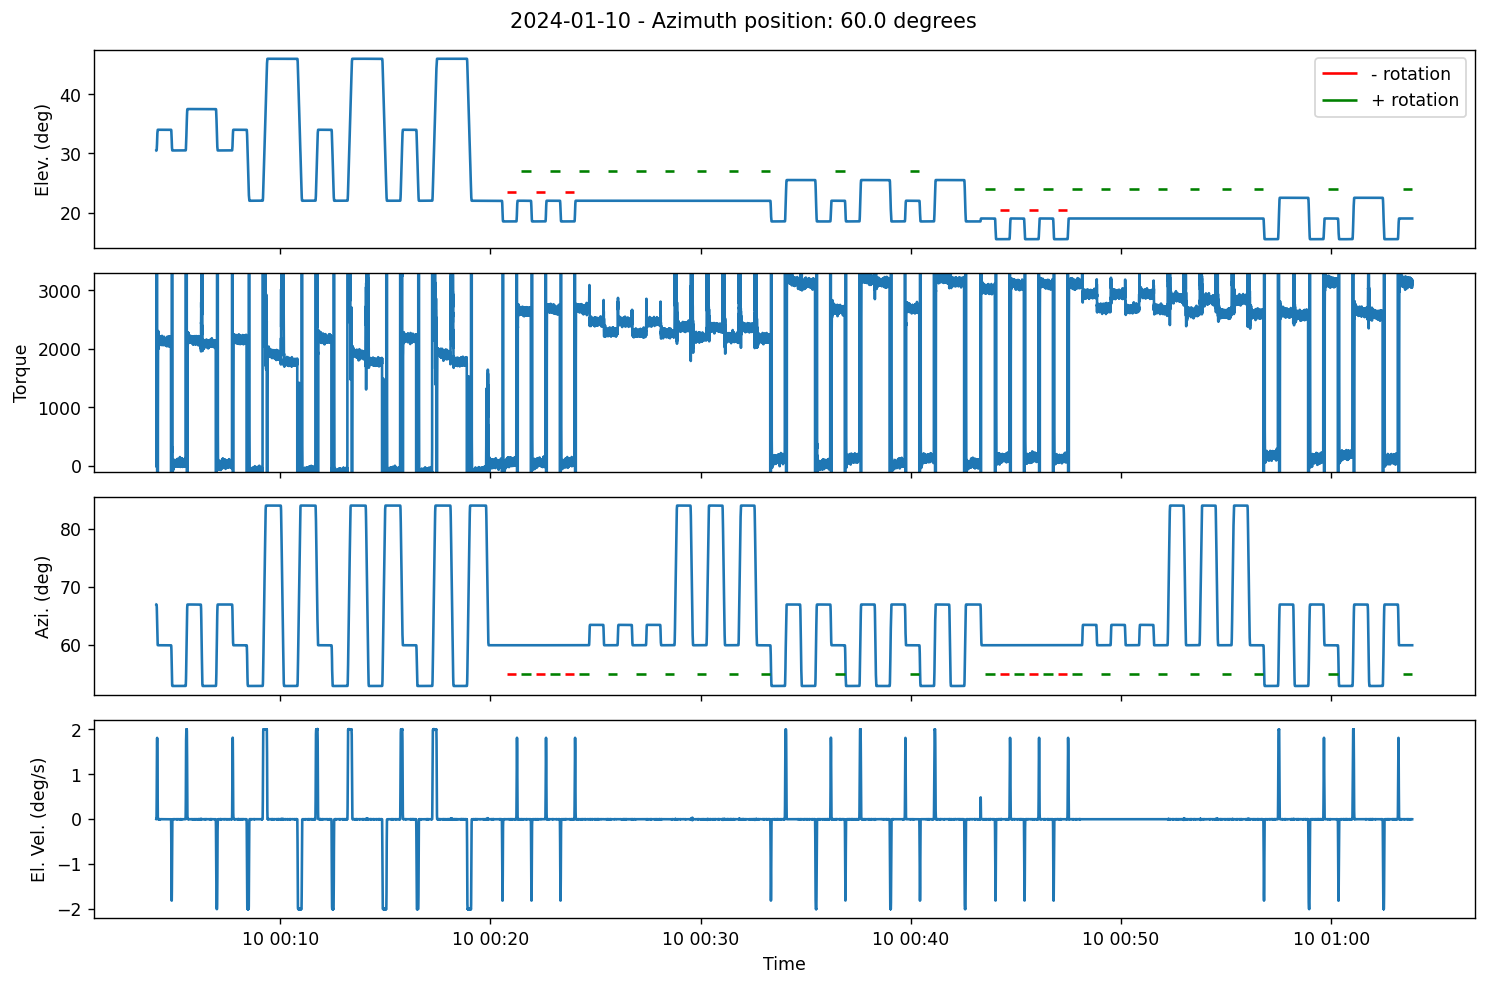

In [11]:
date_dict = {
    "date": "2024-01-10",
    "start_time": "00:20:00.00",
    "end_time": "01:10:00.00",
}
df, sel_azi, client = await init_and_compute(date_dict, "usdf_efd")

# We will retrieve data back t_back seconds in the past
t_back = 1000
plot_history(df, client, t_back, date_dict["date"], sel_azi, plot_dir, save_plot=True)

## Analysis of M1M3 Surrogate and M1M3 Cell on the TMA

### 2023-06-22

In [12]:
date_dict = {
    "date": "2023-06-22",
    "start_time": "00:00:00.00",
    "end_time": "23:59:00.00",
}
df, sel_azi, client = await init_and_compute(date_dict, "usdf_efd")

We found 73 time periods where the TMA is still in both azimuth and elevation
The most common TMA azimuth angle is: 153.0 degrees - # of occurences: 67


### Torque versus elevation angle

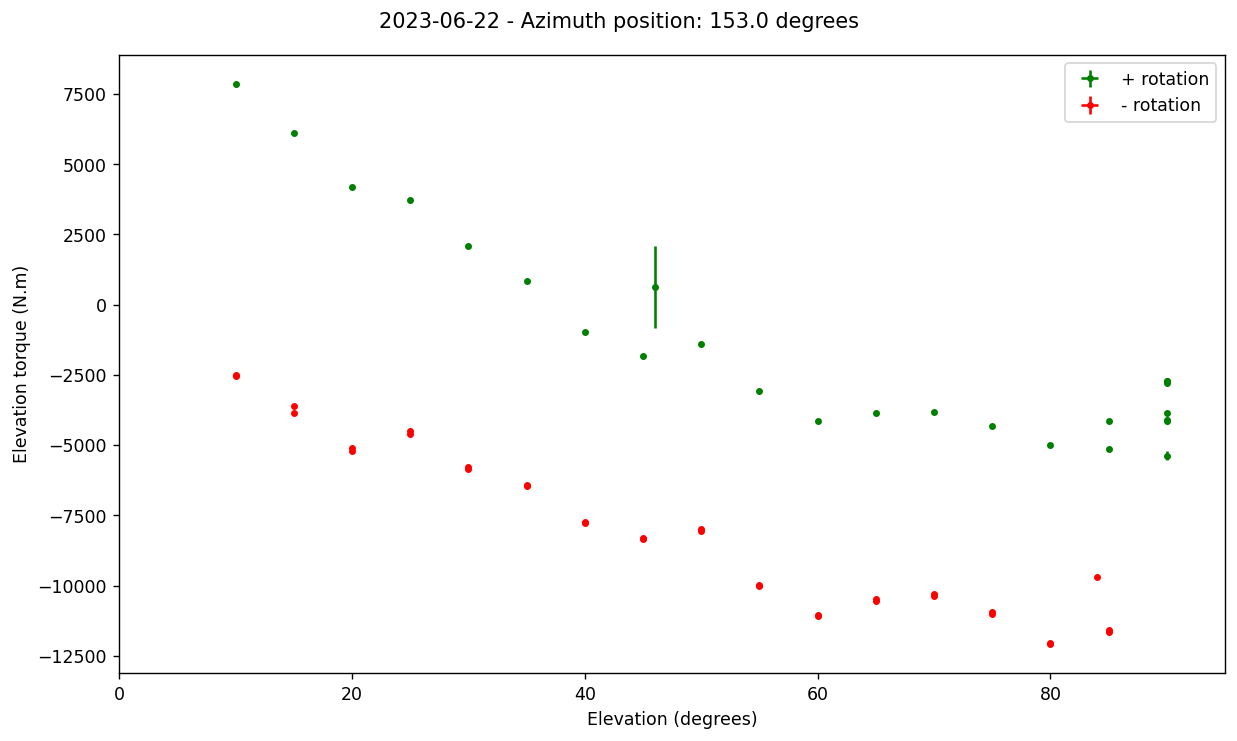

In [13]:
# Plot torque versus elevation angle
plot_torque_versus_elevation(
    df, date_dict["date"], sel_azi, plot_dir, print_numbers=False
)

## Analysis of M2 Surrogate and Cell on the TMA

### 2024-03-28

In [14]:
date_dict = {
    "date": "2024-03-28",
    "start_time": "00:00:00.00",
    "end_time": "23:59:00.00",
}
df, sel_azi, client = await init_and_compute(date_dict, "usdf_efd")

We found 38 time periods where the TMA is still in both azimuth and elevation
The most common TMA azimuth angle is: 152.4 degrees - # of occurences: 31


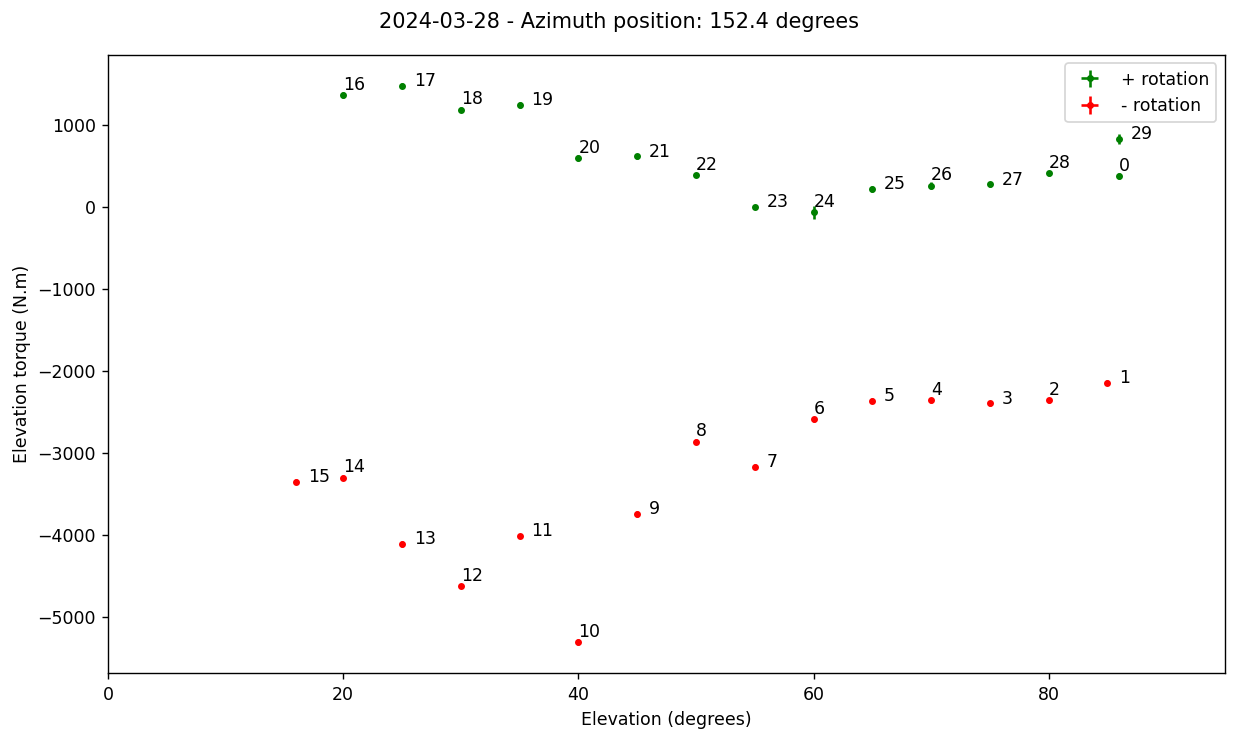

In [15]:
# Plot torque versus elevation angle
plot_torque_versus_elevation(
    df, date_dict["date"], sel_azi, plot_dir, print_numbers=True
)

## Conclusions

- We have produced reference plots for various configurations of mirrors, cells and surrogates on the TMA. These reference plots will be useful during the balancing process of the telescope in its final configuration with glass.
- We have shown the importance to keep the TMA fixed in azimuth during the whole torque versus elevation measurement.
- We have identified an ideal data taking configuration during balancing that guarantee enough data points and a stable azimuth position. The ccurrently existing Block corresponding to this configuration is BLOCK-177.  